In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,6

import warnings
warnings.filterwarnings('ignore')

In [2]:
path='D://SimpliLearn Projects//Machine Learning//Demo Datasets//Lesson 8//'
df = pd.read_csv(path+'AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.shape

(144, 2)

In [4]:
df['Month'] = df['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
df = df.set_index('Month')
df.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [5]:
ts = df['#Passengers']

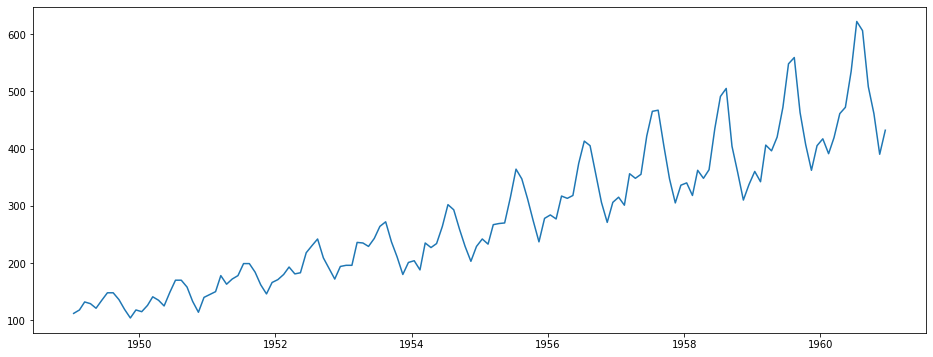

In [6]:
plt.plot(ts)

In [7]:
ts_log = np.log(ts)

In [8]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean & std')
    plt.show(block=False)
    
    print('Result of Dickey - Fuller')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Legs Used', 'Number of Observation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

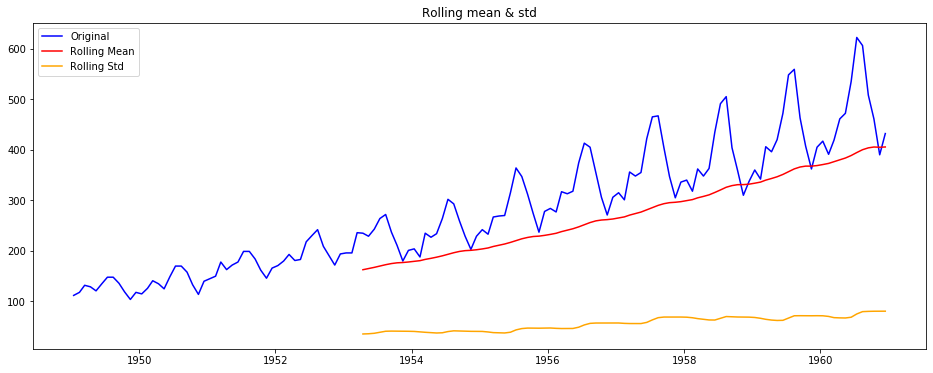

Result of Dickey - Fuller
Test Statistic                  0.815369
p-value                         0.991880
#Legs Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


In [9]:
test_stationarity(df['#Passengers'])

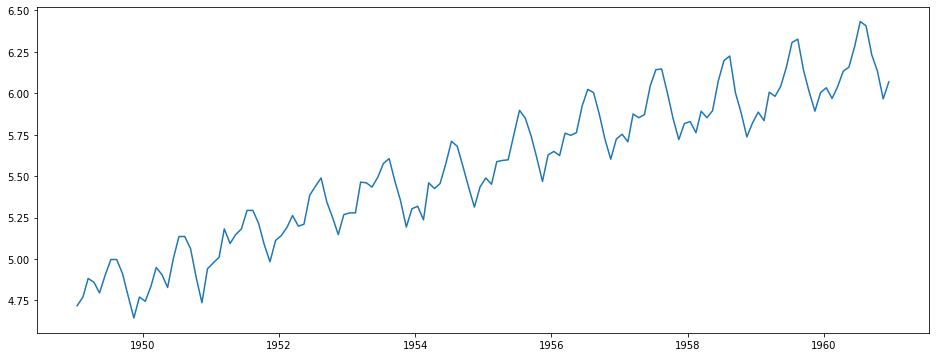

In [10]:
plt.plot(ts_log)

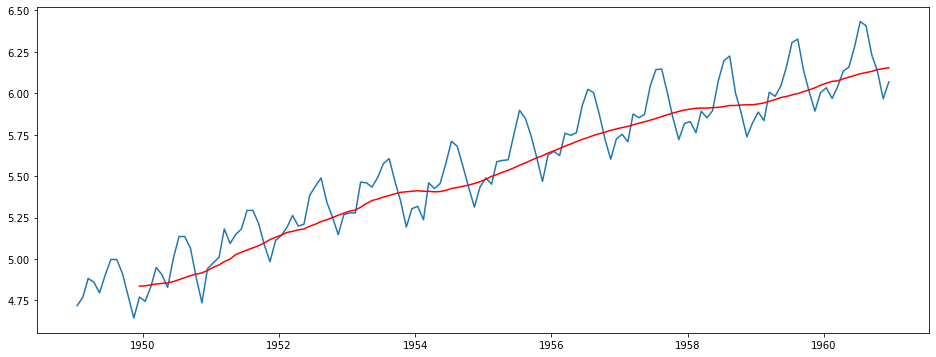

In [12]:
movingAvg = ts_log.rolling(window=12).mean()
movingStd = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAvg, color='red')
#plt.plot(movingStd, color = 'green')

In [13]:
ts_log_mv_diff = ts_log - movingAvg
print(ts_log_mv_diff.head(12))

ts_log_mv_diff.dropna(inplace=True)
print(ts_log_mv_diff.head(10))

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64
Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64


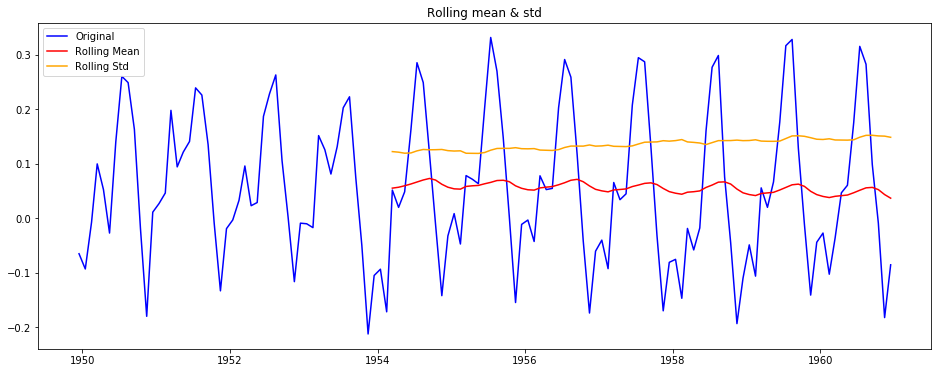

Result of Dickey - Fuller
Test Statistic                 -3.162908
p-value                         0.022235
#Legs Used                     13.000000
Number of Observation Used    119.000000
Critical Value (1%)            -3.486535
Critical Value (5%)            -2.886151
Critical Value (10%)           -2.579896
dtype: float64


In [14]:
test_stationarity(ts_log_mv_diff)

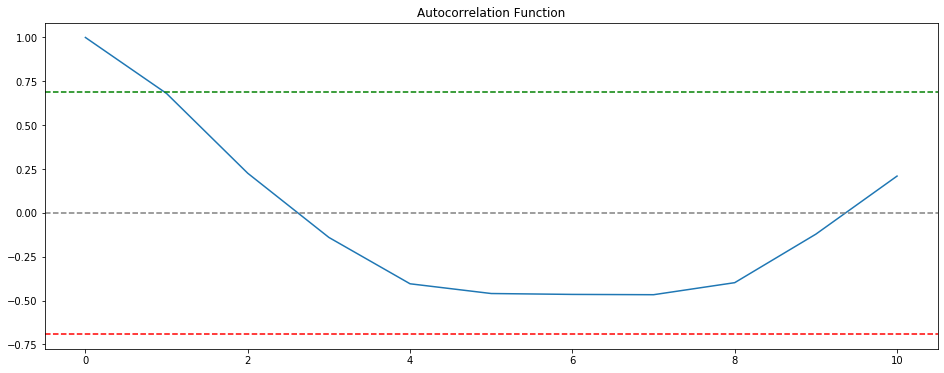

In [16]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
plt.title('Autocorrelation Function')
plt.show()

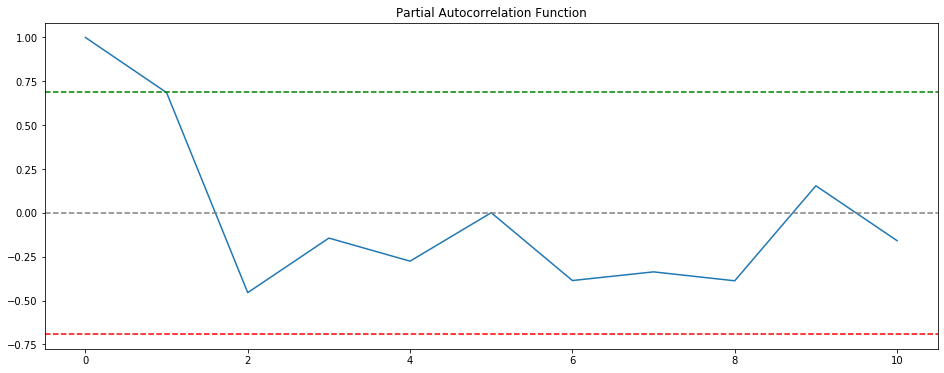

In [18]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
plt.title('Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS: -0.3915')

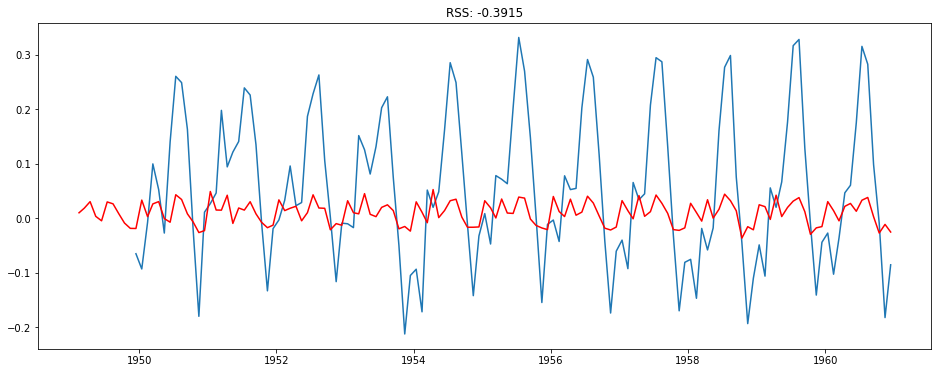

In [19]:
model = ARIMA(ts_log, order=(1,1,0))
result_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum(result_ARIMA.fittedvalues[1] - ts_log_mv_diff**2))

In [20]:
pred_ARIMA_diff = pd.Series(result_ARIMA.fittedvalues, copy=True)
pred_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [21]:
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()
pred_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [24]:
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_diff_cumsum, fill_value=0)
pred_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 4496.4216')

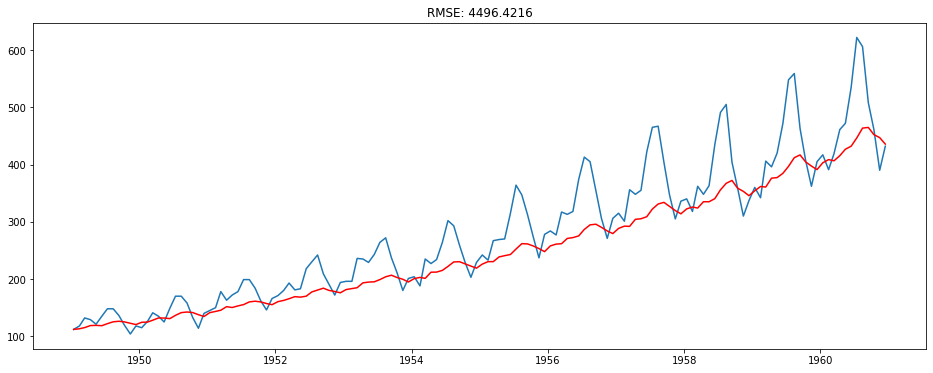

In [28]:
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(ts)
plt.plot(pred_ARIMA, color='red')
plt.title('RMSE: %.4f'%np.sqrt(sum(pred_ARIMA - ts)**2))